# State of the Problem 2: EFFECTS OF URBANIZATION & POPULATION FACTORS TO DENGUE CASES

## PYTHON TOOLS NEEDED

In [10]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt

## SEIR-SEI MODEL

In [11]:
# 1. Model with Environmental Factors
def seir_sei_env(y, t, beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m, pop_density, urban_rate):
    Sh, Eh, Ih, Rh, Sm, Em, Im = y

    # --- Adjust transmission based on urbanization & density ---
    # scale factors (t is time index)
    density_factor = 1 + 0.001 * pop_density[int(t)]      # population density effect
    urban_factor   = 1 + 0.001 * urban_rate[int(t)]       # urbanization effect
    
    beta_h = beta_hv * density_factor * urban_factor
    beta_m = beta_vh * density_factor * urban_factor

    # Total populations
    N_h = Sh + Eh + Ih + Rh
    N_m = Sm + Em + Im
    
    # Human (SEIR) equations
    dShdt = mu_h * N_h - beta_h * Sh * Im / N_h - mu_h * Sh
    dEhdt = (beta_h * Sh * Im / N_h) - (sigma_h + mu_h) * Eh
    dIhdt = (sigma_h * Eh) - (gamma_h + mu_h) * Ih
    dRhdt = (gamma_h * Ih) - (mu_h * Rh)

    # Vector (SEI) equations
    dSmdt = A - beta_m * Sm * Ih / N_h - mu_m * Sm
    dEmdt = (beta_m * Sm * Ih / N_h) - (sigma_m + mu_m) * Em
    dImdt = (sigma_m * Em) - mu_m * Im

    return [dShdt, dEhdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [12]:
# 2. Model without Environmental Factors
def seir_sei_model(y, t, beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m):
    Sh, Eh, Ih, Rh, Sm, Em, Im = y

    # Total populations
    N_h = Sh + Eh + Ih + Rh
    N_m = Sm + Em + Im
    
    # Human (SEIR) equations
    dShdt = mu_h * N_h - beta_hv * Sh * Im / N_h - mu_h * Sh
    dEhdt = (beta_hv * Sh * Im / N_h) - (sigma_h + mu_h) * Eh
    dIhdt = (sigma_h * Eh) - (gamma_h + mu_h) * Ih
    dRhdt = (gamma_h * Ih) - (mu_h * Rh)

    # Vector (SEI) equations
    dSmdt = A - beta_vh * Sm * Ih / N_h - mu_m * Sm
    dEmdt = (beta_vh * Sm * Ih / N_h) - (sigma_m + mu_m) * Em
    dImdt = (sigma_m * Em) - mu_m * Im

    return [dShdt, dEhdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

## ACCURACY EVALUATION CALCULATION

In [13]:
# Function to evaluate model accuracy
def evaluate_model(y_true, y_pred):
    """Calculates RMSE and R-squared."""
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r_squared = r2_score(y_true, y_pred)
    return rmse, r_squared

## SIMULATION AND EVALUATION

In [14]:
dengue_cases = pd.read_csv('2023_cases_x_larvae.csv')

beta_hv = 1/30       # Human-to-vector transmission rate
sigma_h = 1/10       # Human incubation period (5 days)
gamma_h = 1/10      # Human infectious period (10 days)
mu_h = 1/(70*365)   # Human life expectancy (70 years)
A = 44.5            # Mosquito recruitment rate
mu_m = 1/14         # Mosquito lifespan (14 days)
beta_vh = 1/30       # Vector-to-human transmission rate
sigma_m = 1/15      # Mosquito incubation period (10 days)

# human cases primary value
N_h =  dengue_cases['Total_Population'].iloc[-1]
I_h0 = dengue_cases['New_cases'].iloc[-1]
E_h0 = 0
R_h0 = dengue_cases['Total_cases'].iloc[-1]
S_h0 = N_h - I_h0 - E_h0 - R_h0

# mosquito primnary value
N_m = dengue_cases['Total_Mosquito_Population'].iloc[-1]
I_m0 = dengue_cases['Total_Mosquito_Population'].iloc[-1] * 44.5
E_m0 = 0
S_m0 = N_m - I_m0 - E_m0

y0 = [S_h0, E_h0, I_h0, R_h0, S_m0, E_m0, I_m0]


# Time array for a 90-day simulation
time_array = np.arange(0, 90)

# querying data for First Quarter (Jan, Feb, March)
first_quarter_data = dengue_cases.query('Month_Num == 1 | Month_Num == 2 | Month_Num == 3') 

# average Urbanization_Rate rate for 1st quarter
jan_urbanization = first_quarter_data.query('Month_Num == 1')['Urbanization_Rate'].mean()       # average Urbanization_Rate for January
feb_urbanization = first_quarter_data.query('Month_Num == 2')['Urbanization_Rate'].mean()       # average Urbanization_Rate for February
mar_urbanization = first_quarter_data.query('Month_Num == 3')['Urbanization_Rate'].mean()       # average Urbanization_Rate for March

# average Population_Density for 1st quarter
jan_population = first_quarter_data.query('Month_Num == 1')['Population_Density'].mean()    # average Population_Density for January
feb_population = first_quarter_data.query('Month_Num == 2')['Population_Density'].mean()    # average Population_Density for February
mar_population = first_quarter_data.query('Month_Num == 3')['Population_Density'].mean()    # average Population_Density for March

monthly_ave_urbanization = [jan_urbanization, feb_urbanization, mar_urbanization]
monthly_ave_population = [jan_population, feb_population, mar_population]

# Create empty lists to store daily data
urbanization_rate = []
population_density = []

# Set standard deviations (you can adjust these depending on how much variation you want)
urban_rate_std = np.std(dengue_cases['Urbanization_Rate'])  # temperature variation
popu_dens_std = np.std(dengue_cases['Population_Density'])  # rainfall variation 

# Reset daily lists
urbanization_rate = []
population_density = []

days_in_month = 30
for i in range(len(monthly_ave_urbanization)):
    # Generate random values around the mean for each month
    urban_rates = np.random.normal(monthly_ave_urbanization[i], urban_rate_std, days_in_month)
    popu_dens = np.random.normal(monthly_ave_population[i], popu_dens_std, days_in_month)

    # Ensure values stay within reasonable bounds
    urban_rates = np.clip(urban_rates, 0, None)     # rainfall can't be negative
    popu_dens = np.clip(popu_dens, 0, 100)          # humidity is 0–100%

    urbanization_rate.extend(urban_rates)
    population_density.extend(popu_dens)
# days_in_month = 30
# for i in range(len(monthly_ave_population)):
#     urbanization_rate.extend([monthly_ave_population[i]] * days_in_month)
#     population_density.extend([monthly_ave_urbanization[i]] * days_in_month)

### Simulation 1: SEIR-SEI forecast with Environmental Data

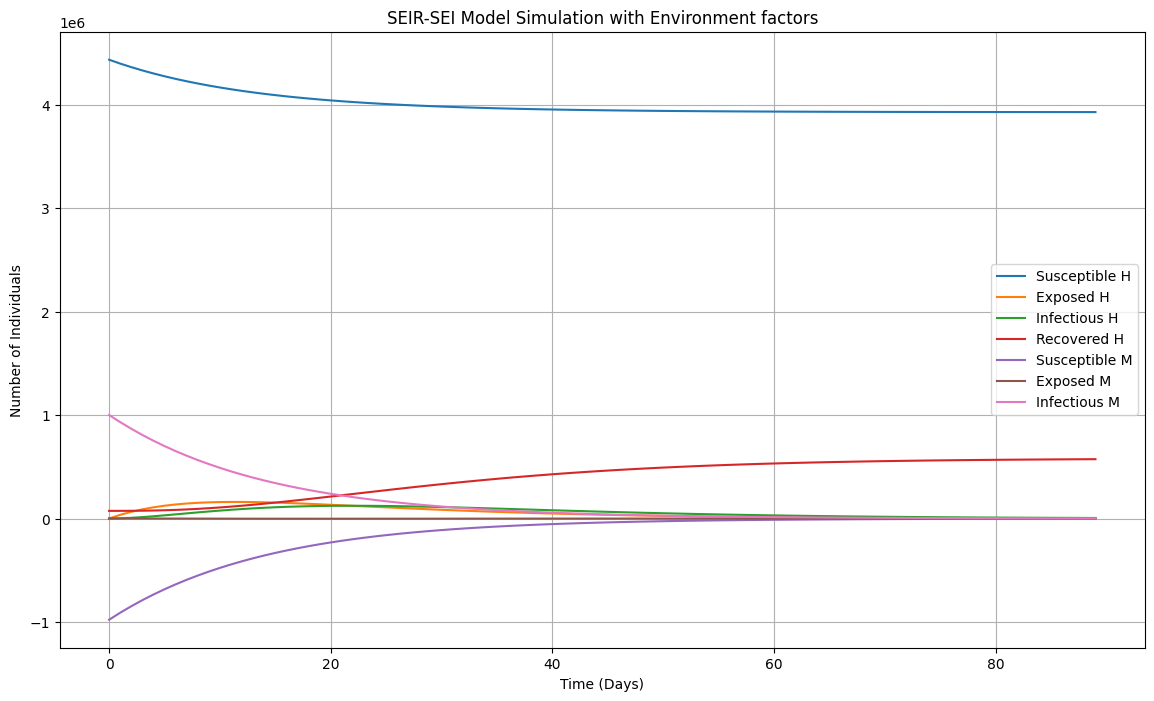

In [15]:
solution_env = odeint(seir_sei_env, y0, time_array, args=(beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m, urbanization_rate, population_density))
simulated_cases_env = solution_env[:, 2] # Index 2 is the 'I' (Infected) compartment

Sh, Eh, Ih, Rh, Sm, Em, Im = solution_env.T # Transpose the solution to get S, E, I, R, S, E, I as separate arrays

# --- Plot the Results ---
plt.figure(figsize=(14, 8))
plt.plot(time_array, Sh, label='Susceptible H')
plt.plot(time_array, Eh, label='Exposed H')
plt.plot(time_array, Ih, label='Infectious H')
plt.plot(time_array, Rh, label='Recovered H')
plt.plot(time_array, Sm, label='Susceptible M')
plt.plot(time_array, Em, label='Exposed M')
plt.plot(time_array, Im, label='Infectious M')
plt.xlabel('Time (Days)')
plt.ylabel('Number of Individuals')
plt.title('SEIR-SEI Model Simulation with Environment factors')
plt.legend()
plt.grid(True)
plt.show()

### Simulation 2: Standard SEIR-SEI forecast 

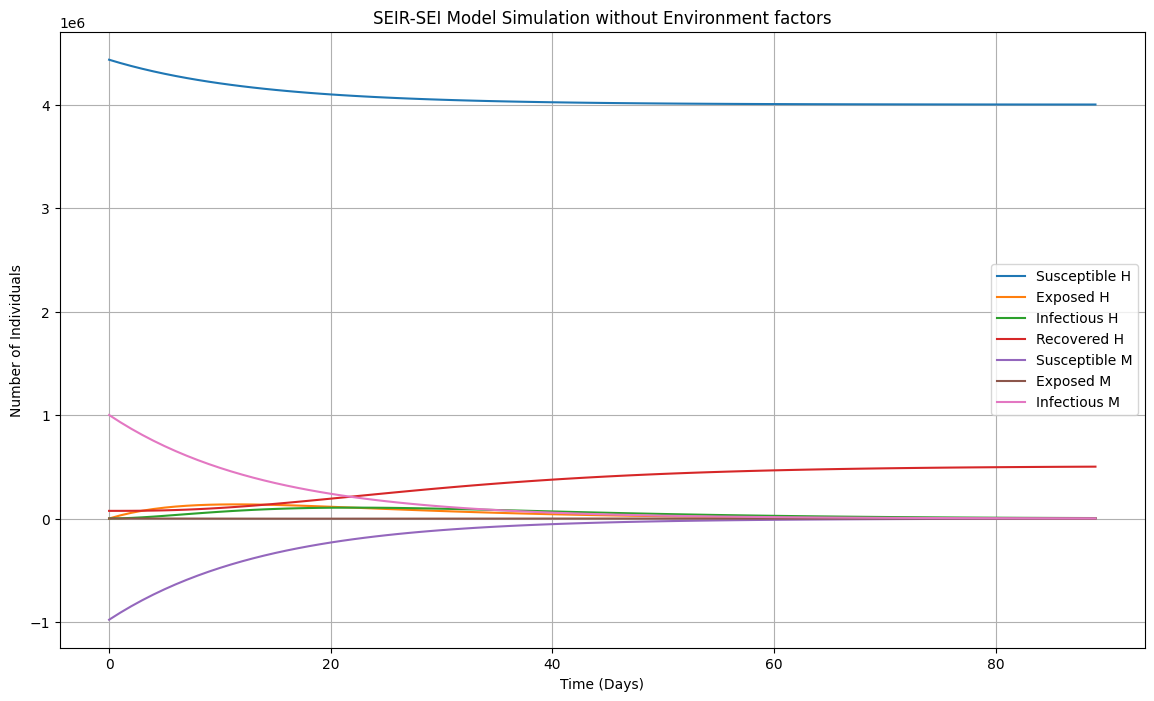

In [16]:
solution = odeint(seir_sei_model, y0, time_array, args=(beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m))
simulated_cases_no_env = solution[:, 2] # Index 2 is the 'I' (Infected) compartment

Sh, Eh, Ih, Rh, Sm, Em, Im = solution.T # Transpose the solution to get S, E, I, R, S, E, I as separate arrays

# --- Plot the Results ---
plt.figure(figsize=(14, 8))
plt.plot(time_array, Sh, label='Susceptible H')
plt.plot(time_array, Eh, label='Exposed H')
plt.plot(time_array, Ih, label='Infectious H')
plt.plot(time_array, Rh, label='Recovered H')
plt.plot(time_array, Sm, label='Susceptible M')
plt.plot(time_array, Em, label='Exposed M')
plt.plot(time_array, Im, label='Infectious M')
plt.xlabel('Time (Days)')
plt.ylabel('Number of Individuals')
plt.title('SEIR-SEI Model Simulation without Environment factors')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Observed data (using our actual data from the past `t` days)
dc = pd.read_csv('cleaned_dengue_data.csv')
observed_cases = dc['New_cases'].tail(len(time_array)).values

## STATISTICAL ANALYSIS AND COMPARISON

In [18]:
# Evaluate the model with Environment factors
rmse_env, r2_env = evaluate_model(observed_cases, simulated_cases_env)
print(f"Model WITH Environment Factors:")
print(f"  RMSE: {rmse_env:.2f}")
print(f"  R-squared: {r2_env:.2f}")

print("-" * 30)

# Evaluate the model without Environment factors
rmse_no_env, r2_no_env = evaluate_model(observed_cases, simulated_cases_no_env)
print(f"Model WITHOUT Environment Factors:")
print(f"  RMSE: {rmse_no_env:.2f}")
print(f"  R-squared: {r2_no_env:.2f}")

# SOP 2: Comparison
print("-" * 30)
if rmse_env < rmse_no_env and r2_env > r2_no_env:
    print("Conclusion: Including Environmental factors IMPROVES forecast accuracy.")
    print("The factors have a significant effect on dengue transmission.")
else:
    print("Conclusion: Including Environmental factors does NOT improve forecast accuracy.")
    print("The factors may not have a significant effect, or the model's formulation needs adjustment.")

Model WITH Environment Factors:
  RMSE: 68673.86
  R-squared: -7274.53
------------------------------
Model WITHOUT Environment Factors:
  RMSE: 58596.88
  R-squared: -5296.01
------------------------------
Conclusion: Including Environmental factors does NOT improve forecast accuracy.
The factors may not have a significant effect, or the model's formulation needs adjustment.
